In [14]:
from __future__ import print_function
import argparse
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt


In [2]:
def seed_it(seed):
    random.seed(seed) #可以注释掉
    os.environ["PYTHONSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) #这个懂吧
    torch.backends.cudnn.deterministic = True #确定性固定
    torch.backends.cudnn.benchmark = True #False会确定性地选择算法，会降低性能
    torch.backends.cudnn.enabled = True  #增加运行效率，默认就是True
    torch.manual_seed(seed)
seed_it(1314)

In [4]:
class Generator(nn.Module):
    def __init__(self, nc=10, nz=100, n_out=1, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz+nc, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, n_out, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc+1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [6]:
dataset = dset.MNIST(root='./data', download=True,
                     transform=transforms.Compose([
                         #transforms.Resize(imageSize),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5,), (0.5,)),
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nc = 1
nz = 100
ngf = 64
ndf = 64

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
netG = Generator(ngf=ngf).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)


In [9]:
netD = Discriminator(ndf=ndf).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [10]:
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

In [110]:
for i, data in enumerate(dataloader, 0):
    images, conditions = data
    break

In [111]:
real_conditions = torch.unsqueeze(conditions,1).expand(len(conditions),10)
real_conditions = torch.unsqueeze(real_conditions,2)
real_conditions = torch.unsqueeze(real_conditions,3)
g_input = torch.cat([fixed_noise.cpu(), real_conditions], 1)

In [112]:
d_conditions = torch.unsqueeze(conditions,1)
d_conditions = torch.unsqueeze(d_conditions,2)
d_conditions = torch.unsqueeze(d_conditions,3)
d_conditions = d_conditions.expand(-1,-1,28,28)
d_input = torch.cat([images, d_conditions], 1)

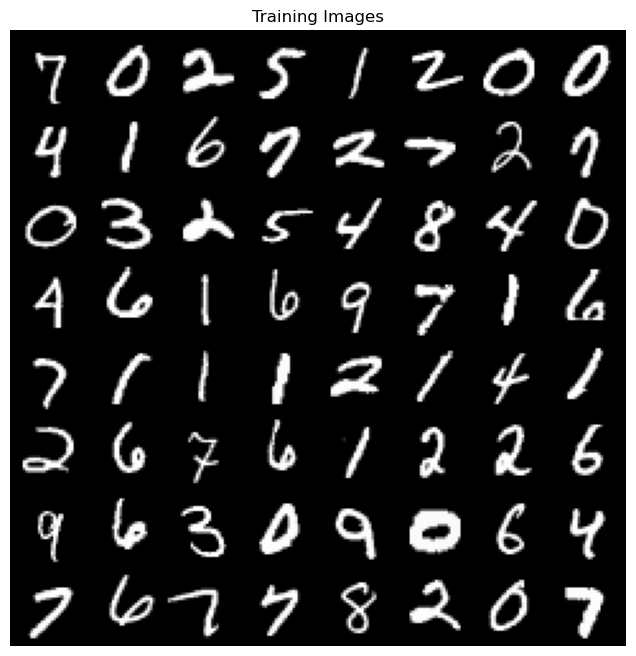

In [114]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [140]:
fixed_noise = torch.randn(80, nz, 1, 1, device=device)

In [141]:
fixed_conditions = torch.unsqueeze(torch.tensor([0,1,2,3,4,5,6,7,8,9]),1).expand(10,8).reshape(-1)
fixed_conditions = torch.unsqueeze(fixed_conditions,1).expand(80,10)
fixed_conditions = torch.unsqueeze(fixed_conditions,2)
fixed_conditions = torch.unsqueeze(fixed_conditions,3)
fixed_conditions = fixed_conditions.to(device)

In [142]:
fixed_input = torch.cat([fixed_noise, fixed_conditions], 1)

In [143]:
fixed_input.shape

torch.Size([80, 110, 1, 1])

In [151]:
outf = './checkpoint_cgan'
#os.mkdir(outf)

criterion = nn.BCELoss()
real_label = 1.
fake_label = 0.

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))


img_list = []
G_losses = []
D_losses = []


for epoch in range(25):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        
        images, real_conditions = data
        
        real_cpu = images.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        real_d_conditions = torch.unsqueeze(real_conditions,1)
        real_d_conditions = torch.unsqueeze(real_d_conditions,2)
        real_d_conditions = torch.unsqueeze(real_d_conditions,3)
        real_d_conditions = real_d_conditions.expand(-1,-1,28,28)
        real_d_conditions = real_d_conditions.to(device)
        
        real_d_input = torch.cat([real_cpu, real_d_conditions], 1)

        output = netD(real_d_input).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        
        fake_conditions = torch.randint(0, 10, (batch_size,)).to(device)
        
        fake_g_conditions = torch.unsqueeze(fake_conditions,1).expand(batch_size,10)
        fake_g_conditions = torch.unsqueeze(fake_g_conditions,2)
        fake_g_conditions = torch.unsqueeze(fake_g_conditions,3)
        fake_g_conditions = fake_g_conditions.to(device)
        fake_g_input = torch.cat([noise, fake_g_conditions], 1)
        
        fake = netG(fake_g_input)
        label.fill_(fake_label)
        
        fake_d_conditions = torch.unsqueeze(fake_conditions,1)
        fake_d_conditions = torch.unsqueeze(fake_d_conditions,2)
        fake_d_conditions = torch.unsqueeze(fake_d_conditions,3)
        fake_d_conditions = fake_d_conditions.expand(-1,-1,28,28)
        fake_d_conditions = fake_d_conditions.to(device)
        
        fake_d_input = torch.cat([fake, fake_d_conditions], 1)
        
        output = netD(fake_d_input.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        output = netD(fake_d_input).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()


        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, 25, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    with torch.no_grad():
        fake = netG(fixed_input).detach().cpu()
    vutils.save_image(fake.detach(),
                      '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                      normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/25][0/469]	Loss_D: 1.4975	Loss_G: 0.3323	D(x): 0.3529	D(G(z)): 0.0356 / 0.7665
[0/25][100/469]	Loss_D: 0.2949	Loss_G: 2.8926	D(x): 0.8222	D(G(z)): 0.0508 / 0.0597
[0/25][200/469]	Loss_D: 0.8033	Loss_G: 2.7117	D(x): 0.7841	D(G(z)): 0.3540 / 0.0876
[0/25][300/469]	Loss_D: 0.8427	Loss_G: 1.6462	D(x): 0.5601	D(G(z)): 0.0913 / 0.2194
[0/25][400/469]	Loss_D: 1.5496	Loss_G: 1.5021	D(x): 0.4078	D(G(z)): 0.2061 / 0.2549
[1/25][0/469]	Loss_D: 1.0966	Loss_G: 1.9123	D(x): 0.5989	D(G(z)): 0.3149 / 0.1836
[1/25][100/469]	Loss_D: 0.6016	Loss_G: 2.5382	D(x): 0.8876	D(G(z)): 0.3519 / 0.1340
[1/25][200/469]	Loss_D: 1.0222	Loss_G: 2.0412	D(x): 0.7284	D(G(z)): 0.4477 / 0.1889
[1/25][300/469]	Loss_D: 0.6802	Loss_G: 1.9503	D(x): 0.7374	D(G(z)): 0.2676 / 0.1707
[1/25][400/469]	Loss_D: 0.9627	Loss_G: 1.1353	D(x): 0.5198	D(G(z)): 0.1988 / 0.3838
[2/25][0/469]	Loss_D: 0.6459	Loss_G: 1.9556	D(x): 0.8202	D(G(z)): 0.3284 / 0.1770
[2/25][100/469]	Loss_D: 1.4945	Loss_G: 1.1653	D(x): 0.5607	D(G(z)): 0.5235 / 0.360

[19/25][300/469]	Loss_D: 1.6429	Loss_G: 0.6641	D(x): 0.3823	D(G(z)): 0.4763 / 0.5193
[19/25][400/469]	Loss_D: 1.4630	Loss_G: 0.8041	D(x): 0.4154	D(G(z)): 0.4253 / 0.4522
[20/25][0/469]	Loss_D: 1.8410	Loss_G: 0.6470	D(x): 0.6360	D(G(z)): 0.7412 / 0.5334
[20/25][100/469]	Loss_D: 1.6922	Loss_G: 0.6458	D(x): 0.4086	D(G(z)): 0.5300 / 0.5277
[20/25][200/469]	Loss_D: 1.0149	Loss_G: 1.0399	D(x): 0.7025	D(G(z)): 0.4738 / 0.3658
[20/25][300/469]	Loss_D: 1.3732	Loss_G: 0.7982	D(x): 0.5028	D(G(z)): 0.4836 / 0.4556
[20/25][400/469]	Loss_D: 1.0034	Loss_G: 0.9604	D(x): 0.6522	D(G(z)): 0.4278 / 0.3901
[21/25][0/469]	Loss_D: 1.1962	Loss_G: 1.1752	D(x): 0.4171	D(G(z)): 0.2560 / 0.3150
[21/25][100/469]	Loss_D: 1.3520	Loss_G: 0.9935	D(x): 0.6417	D(G(z)): 0.5866 / 0.3841
[21/25][200/469]	Loss_D: 1.7458	Loss_G: 0.6426	D(x): 0.4109	D(G(z)): 0.5609 / 0.5325
[21/25][300/469]	Loss_D: 1.1223	Loss_G: 0.9928	D(x): 0.6481	D(G(z)): 0.4900 / 0.3776
[21/25][400/469]	Loss_D: 1.5119	Loss_G: 0.8235	D(x): 0.5578	D(G(z)): 

In [152]:
torch.save(fixed_input, './fixed_input.pth')

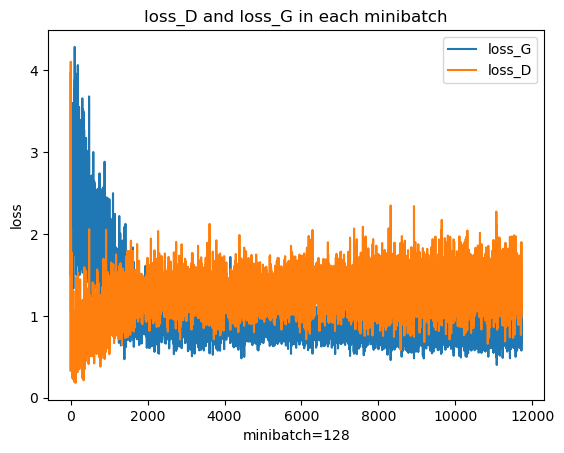

In [153]:
import matplotlib.pyplot as plt
x_lim = range(len(G_losses))
plt.plot(x_lim, G_losses, label='loss_G')
plt.plot(x_lim, D_losses, label='loss_D')
plt.xlabel('minibatch=128')
plt.ylabel('loss')
plt.title('loss_D and loss_G in each minibatch')
plt.legend()
plt.show()

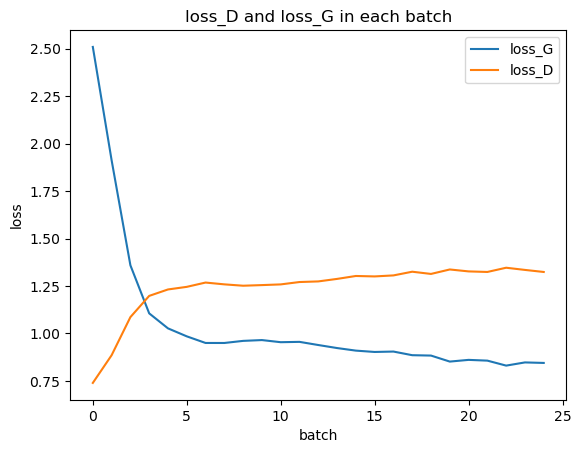

In [154]:
G_batch_loss = []
D_batch_loss = []
g_loss = 0
d_loss = 0
batch = 469
for i in range(25):
    for j in range(469):
        g_loss = g_loss + G_losses[i*batch+j]
        d_loss = d_loss + D_losses[i*batch+j]
    g_loss = g_loss/469
    d_loss = d_loss/469
    
    G_batch_loss.append(g_loss)
    D_batch_loss.append(d_loss)
    
    g_loss = 0
    d_loss = 0
    
x_lim = range(25)
plt.plot(x_lim, G_batch_loss,label='loss_G')
plt.plot(x_lim, D_batch_loss,label='loss_D')
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('loss_D and loss_G in each batch')
plt.legend()
plt.show()